<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [ ]:
pip install --upgrade tensorflow

In [ ]:
import tensorflow as tf

tf.__version__

'2.13.0'

In [ ]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [ ]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1

def transform_data(x):
  if x<=2:
    return 0
  elif x==3:
    return 1
  else:
    return 2

df_reviews['Rating']=df_reviews['Rating'].apply(transform_data)
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,2
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",2
4,This shirt is very flattering to all due to th...,2


In [ ]:
df_reviews['Rating'].value_counts()

2    12540
0     5193
1     4908
Name: Rating, dtype: int64

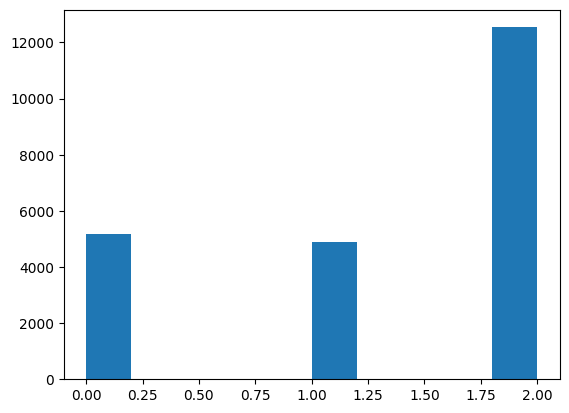

In [ ]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
plt.hist(df_reviews['Rating']);

In [ ]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
X=np.array(df_reviews['Review Text'])

In [ ]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
X.shape

(22641,)

In [ ]:
# Alumno: Concatenar todas las reviews para armar el corpus
text_sequences = df_reviews['Review Text'].values
corpus = ' '.join(text_sequences)

In [ ]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [ ]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [ ]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [ ]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [ ]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(tokens)

In [ ]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [ ]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [ ]:
# Alumno: Determinar cual es la oración más larga
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')

el máximo es 115


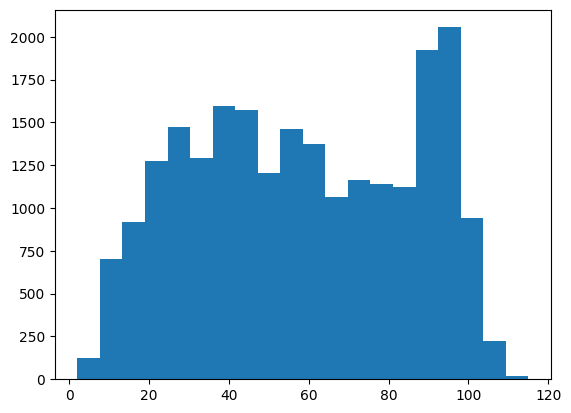

In [ ]:
# y también explorar cómo es la distribución de tamaños de secuencias
plt.figure()
plt.hist(seqs_lenght,bins=20);

In [ ]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [ ]:
# qué porcentaje de los datos se procesan completamente
(np.array(seqs_lenght)<maxlen).mean()

0.999955832339561

In [ ]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [ ]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = pd.get_dummies(df_reviews['Rating'])
print(y.shape)

(22641, 3)


In [ ]:
y.head()

,0,1,2
0,0,1,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1


In [ ]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [ ]:
y_train.value_counts(normalize=True)

0  1  2
0  0  1    0.552838
1  0  0    0.230952
0  1  0    0.216210
dtype: float64

In [ ]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = y_train.shape[1] # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 3


### 2 - Definir el modelo con Embeddings + LSTM

In [ ]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.metrics import Metric


model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.F1Score(average='macro', threshold=0.5, name='f1_score')]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 115, 50)           100050    
                                                                 
 lstm_8 (LSTM)               (None, 115, 64)           29440     
                                                                 
 dropout_8 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##3.1 Entrenamiento de las tres clases sin balancear



In [ ]:
y_train_1 = tf.cast(y_train, dtype=tf.float32)
hist=model.fit(X_train, y_train_1, epochs=5, validation_split=0.2)

Epoch 1/5
453/453 [==============================] - 88s 183ms/step - loss: 0.7751 - accuracy: 0.6686 - precision_3: 0.5760 - recall_3: 0.7137 - f1_score: 0.5395 - val_loss: 0.7014 - val_accuracy: 0.7027 - val_precision_3: 0.6925 - val_recall_3: 0.7110 - val_f1_score: 0.5413
Epoch 2/5
453/453 [==============================] - 77s 171ms/step - loss: 0.6481 - accuracy: 0.7238 - precision_3: 0.5392 - recall_3: 0.8583 - f1_score: 0.6444 - val_loss: 0.6749 - val_accuracy: 0.7077 - val_precision_3: 0.5350 - val_recall_3: 0.8562 - val_f1_score: 0.6420
Epoch 3/5
453/453 [==============================] - 80s 177ms/step - loss: 0.6006 - accuracy: 0.7417 - precision_3: 0.5468 - recall_3: 0.8982 - f1_score: 0.6738 - val_loss: 0.6769 - val_accuracy: 0.7163 - val_precision_3: 0.4895 - val_recall_3: 0.8946 - val_f1_score: 0.6420
Epoch 4/5
453/453 [==============================] - 81s 180ms/step - loss: 0.5568 - accuracy: 0.7620 - precision_3: 0.5639 - recall_3: 0.9150 - f1_score: 0.6944 - val_loss

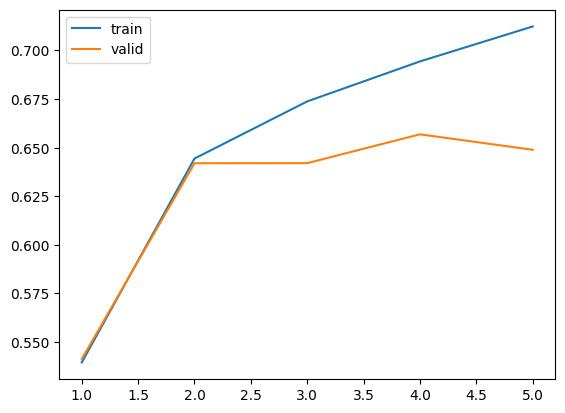

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['f1_score']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['f1_score'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_f1_score'], label='valid')
plt.show()

##3.2 Entrenamiento de todas las clases balanceadas 8000 muestras

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Separar características y etiquetas

sampling_strategy = {0:8000,
                     1:8000}

oversampler = RandomOverSampler(sampling_strategy=sampling_strategy)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X_train), np.array(y_train))

# Aplicar undersampling a la clase 2
rus = RandomUnderSampler(sampling_strategy={2: 8000})
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

y_resampled=pd.DataFrame(y_resampled)
X_resampled=pd.DataFrame(X_resampled)

y_resampled.value_counts()


0  1  2
0  0  1    8000
   1  0    8000
1  0  0    8000
dtype: int64

In [ ]:
print(X_resampled.shape ,y_resampled.shape)

(24000, 115) (24000, 3)


In [ ]:
in_shape = X_resampled.shape[1] # max input sentence len
out_shape = y_resampled.shape[1] # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 3


In [ ]:
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.metrics import Metric

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.F1Score(average='macro', threshold=0.5, name='f1_score')]
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 115, 50)           100050    
                                                                 
 lstm_12 (LSTM)              (None, 115, 64)           29440     
                                                                 
 dropout_12 (Dropout)        (None, 115, 64)           0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 3)                

In [ ]:
y_resampled_1 = tf.cast(y_resampled, dtype=tf.float32)
hist1=model.fit(X_resampled, y_resampled_1, epochs=5, validation_split=0.2)

Epoch 1/5
600/600 [==============================] - 100s 145ms/step - loss: 0.7764 - accuracy: 0.6326 - precision_5: 0.4881 - recall_5: 0.8840 - f1_score: 0.6021 - val_loss: 1.0912 - val_accuracy: 0.3567 - val_precision_5: 0.4208 - val_recall_5: 0.7960 - val_f1_score: 0.2955
Epoch 2/5
600/600 [==============================] - 89s 148ms/step - loss: 0.6079 - accuracy: 0.7443 - precision_5: 0.5410 - recall_5: 0.9147 - f1_score: 0.6757 - val_loss: 1.0067 - val_accuracy: 0.5821 - val_precision_5: 0.4079 - val_recall_5: 0.7415 - val_f1_score: 0.2838
Epoch 3/5
600/600 [==============================] - 94s 157ms/step - loss: 0.5155 - accuracy: 0.7945 - precision_5: 0.5986 - recall_5: 0.9240 - f1_score: 0.7162 - val_loss: 1.2337 - val_accuracy: 0.5123 - val_precision_5: 0.4130 - val_recall_5: 0.7150 - val_f1_score: 0.2779
Epoch 4/5
600/600 [==============================] - 104s 173ms/step - loss: 0.4415 - accuracy: 0.8324 - precision_5: 0.6496 - recall_5: 0.9381 - f1_score: 0.7515 - val_lo

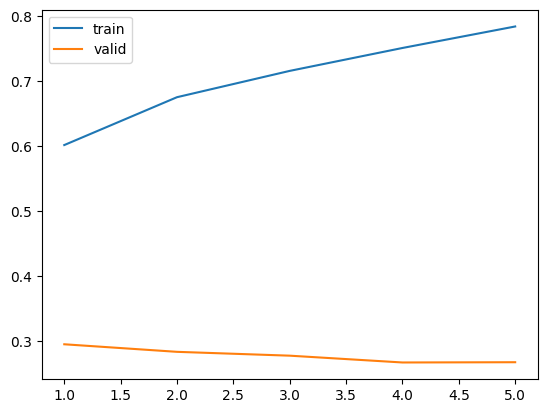

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['f1_score']) + 1)
sns.lineplot(x=epoch_count,  y=hist1.history['f1_score'], label='train')
sns.lineplot(x=epoch_count,  y=hist1.history['val_f1_score'], label='valid')
plt.show()